In [1]:
import json
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import folium
import ipinfo
import numpy as np
from datetime import datetime
from zipfile import ZipFile
import cbor2
from tqdm import tqdm


In [2]:
def get_cdf_data(values):
    sorted_values = np.sort(values)
    cdf = np.arange(len(sorted_values)) / len(sorted_values)
    return sorted_values, cdf

In [3]:
CCAS = ["reno", "cubic", "bbr", "fast"]
MARKERS = ["d", "v", "1", "."]
MARKERS = [".", ".", ".", "."]


# NesQUIC

## Bandwidth

In [4]:
folder = os.path.join("labo_tests", "nesquic_wsp_2", "logs")

out = []

for test in os.listdir(folder):
    test_folder = os.path.join(folder, test)
    results = os.listdir(test_folder)
    latest_zip = max([(datetime.strptime(e.rstrip(".zip"),
                     "%a_%b_%d_%H:%M:%S_%Y"), e) for e in results])[1]
    data = None
    with ZipFile(os.path.join(test_folder, latest_zip)) as zo:
        data = json.load(zo.open("output.json"))
    curr = {
        "expected": int(test.split("_")[1].rstrip("mbit")),
        "latency": 2*int(test.split("_")[2].rstrip("ms"))
    }
    for method in data:
        for way in method['ways']:
            # print(method, way)
            for param in way["params"]:
                test_name = f"{method['method']}_{way['way']}_{param['param'].split(' ')[0]}"
                infos = param["infos"]
                curr_bw = (8*infos["data_exchanged"])/infos["elapsed_s"]
                curr[test_name] = round(curr_bw/1000000, 2)
    out.append(curr)

df = pd.DataFrame(out)

In [5]:
df

,expected,latency,bulk_download_reno,bulk_download_bbr,bulk_download_cubic,bulk_download_fast,bulk_upload_reno,bulk_upload_bbr,bulk_upload_cubic,bulk_upload_fast,...,limited_download_0.8,limited_download_0.9,limited_download_1.0,limited_download_1.1,limited_upload_0.3,limited_upload_0.5,limited_upload_0.8,limited_upload_0.9,limited_upload_1.0,limited_upload_1.1
0,69,202,36.86,52.26,49.08,0.55,27.97,51.91,48.17,0.55,...,52.88,59.49,64.14,64.19,18.32,31.70,50.72,57.06,63.39,64.16
1,66,160,45.14,53.24,53.21,0.67,43.88,53.60,50.62,0.68,...,48.79,54.89,60.99,61.42,17.73,30.73,49.17,55.32,61.46,61.64
2,40,154,24.38,34.99,34.85,0.70,35.20,34.96,34.28,0.70,...,30.09,33.85,37.61,37.42,10.92,18.62,29.80,33.52,37.24,37.42
3,48,32,36.01,44.68,44.87,3.19,44.72,44.62,44.70,2.33,...,34.95,39.32,43.68,45.40,13.04,22.61,36.19,40.72,45.47,45.39
4,96,110,64.28,77.46,77.39,0.98,44.55,76.64,76.29,0.97,...,70.71,79.54,88.38,90.05,25.01,44.48,71.16,80.07,88.94,90.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,85,222,36.85,57.69,56.29,0.50,51.25,58.69,54.91,0.50,...,59.05,66.43,73.81,78.83,20.68,35.97,57.53,64.73,71.93,79.12
133,98,22,44.97,90.23,90.56,4.31,76.14,89.88,89.78,3.19,...,73.25,82.39,91.51,91.62,25.86,46.34,74.13,83.42,92.82,92.76
134,77,146,44.87,61.30,61.26,0.73,39.60,61.67,58.57,0.74,...,56.90,64.01,71.10,71.97,20.30,35.88,57.40,64.58,71.74,72.00
135,3,220,2.14,2.69,2.42,0.51,2.76,2.81,2.78,0.51,...,2.24,2.52,2.80,2.83,0.82,1.36,2.18,2.45,2.73,2.83


In [6]:
subdf = pd.DataFrame({
    "expected_bw" : df["expected"],
    "latency" : df["latency"],

    "ratio_reno_dl": df.apply(lambda r: 100*r["bulk_download_reno"]/r["expected"], axis=1),
    "ratio_bbr_dl": df.apply(lambda r: 100*r["bulk_download_bbr"]/r["expected"], axis=1),
    "ratio_fast_dl": df.apply(lambda r: 100*r["bulk_download_fast"]/r["expected"], axis=1),
    "ratio_cubic_dl": df.apply(lambda r: 100*r["bulk_download_cubic"]/r["expected"], axis=1),

    "ratio_reno_ul": df.apply(lambda r: 100*r["bulk_upload_reno"]/r["expected"], axis=1),
    "ratio_bbr_ul": df.apply(lambda r: 100*r["bulk_upload_bbr"]/r["expected"], axis=1),
    "ratio_fast_ul": df.apply(lambda r: 100*r["bulk_upload_fast"]/r["expected"], axis=1),
    "ratio_cubic_ul": df.apply(lambda r: 100*r["bulk_upload_cubic"]/r["expected"], axis=1),
})

In [7]:
subdf

,expected_bw,latency,ratio_reno_dl,ratio_bbr_dl,ratio_fast_dl,ratio_cubic_dl,ratio_reno_ul,ratio_bbr_ul,ratio_fast_ul,ratio_cubic_ul
0,69,202,53.420290,75.739130,0.797101,71.130435,40.536232,75.231884,0.797101,69.811594
1,66,160,68.393939,80.666667,1.015152,80.621212,66.484848,81.212121,1.030303,76.696970
2,40,154,60.950000,87.475000,1.750000,87.125000,88.000000,87.400000,1.750000,85.700000
3,48,32,75.020833,93.083333,6.645833,93.479167,93.166667,92.958333,4.854167,93.125000
4,96,110,66.958333,80.687500,1.020833,80.614583,46.406250,79.833333,1.010417,79.468750
...,...,...,...,...,...,...,...,...,...,...
132,85,222,43.352941,67.870588,0.588235,66.223529,60.294118,69.047059,0.588235,64.600000
133,98,22,45.887755,92.071429,4.397959,92.408163,77.693878,91.714286,3.255102,91.612245
134,77,146,58.272727,79.610390,0.948052,79.558442,51.428571,80.090909,0.961039,76.064935
135,3,220,71.333333,89.666667,17.000000,80.666667,92.000000,93.666667,17.000000,92.666667


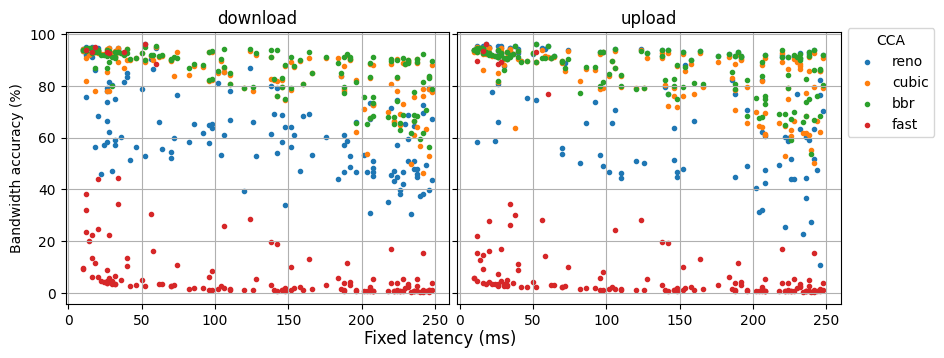

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 4))
for cca, marker in zip(CCAS, MARKERS):
    ax1.scatter(subdf["latency"], subdf[f"ratio_{cca}_dl"], label=cca, marker=marker)
    ax2.scatter(subdf["latency"], subdf[f"ratio_{cca}_ul"], label=cca, marker=marker)
fig.supxlabel("Fixed latency (ms)")
ax1.set_ylabel("Bandwidth accuracy (%)")
ax1.set_title("download")
ax2.set_title("upload")
ax1.grid()
ax2.grid()

# ax1.set_xscale("log")
# ax2.set_xscale("log")

plt.legend(title="CCA", bbox_to_anchor=(1, 1.04))

plt.subplots_adjust(wspace=0.02, hspace=0.2, top=0.8, bottom=0.12)
# plt.savefig("output/increase_loss.pdf")


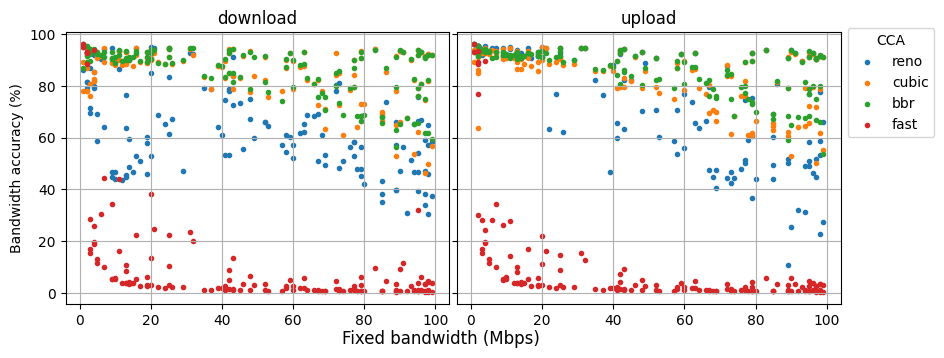

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 4))
for cca, marker in zip(CCAS, MARKERS):
    ax1.scatter(subdf["expected_bw"], subdf[f"ratio_{cca}_dl"], label=cca, marker=marker)
    ax2.scatter(subdf["expected_bw"], subdf[f"ratio_{cca}_ul"], label=cca, marker=marker)
fig.supxlabel("Fixed bandwidth (Mbps)")
ax1.set_ylabel("Bandwidth accuracy (%)")
ax1.set_title("download")
ax2.set_title("upload")
ax1.grid()
ax2.grid()

# ax1.set_xscale("log")
# ax2.set_xscale("log")

plt.legend(title="CCA", bbox_to_anchor=(1, 1.04))

plt.subplots_adjust(wspace=0.02, hspace=0.2, top=0.8, bottom=0.12)
# plt.savefig("output/increase_loss.pdf")


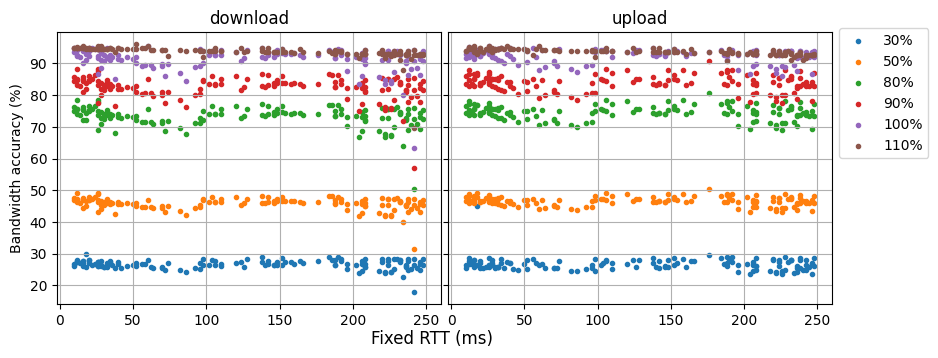

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 4))
for test in [c for c in df.columns if c.startswith("limited") and "upload" in c]:
    label = f"{int(100*float(test.split('_')[-1]))}%"
    ax1.scatter(df["latency"],
                100*df[test]/df["expected"], marker='.')
    ax2.scatter(df["latency"],
                100*df[test.replace("up", "down")]/df["expected"], label=label, marker='.')
fig.supxlabel("Fixed RTT (ms)")
ax1.set_ylabel("Bandwidth accuracy (%)")
ax1.set_title("download")
ax2.set_title("upload")
ax1.grid()
ax2.grid()

plt.legend(bbox_to_anchor=(1, 1.04))

plt.subplots_adjust(wspace=0.02, hspace=0.2, top=0.8, bottom=0.12)
plt.savefig("output/NesQUIClab/limited_acc_lat.pdf")


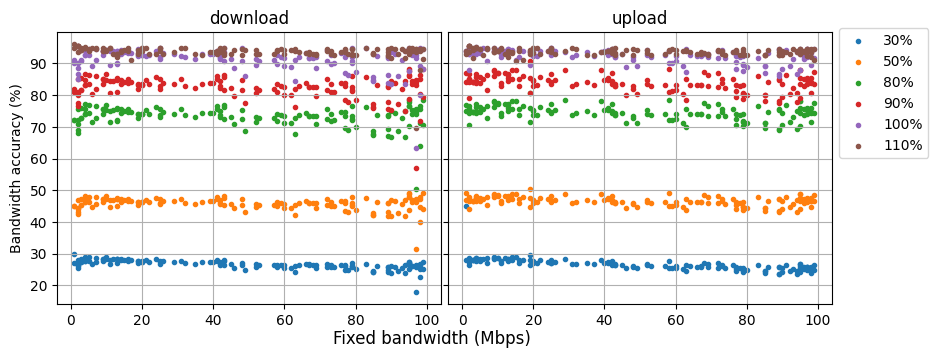

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 4))
for test in [c for c in df.columns if c.startswith("limited") and "upload" in c]:
    label = f"{int(100*float(test.split('_')[-1]))}%"
    ax1.scatter(df["expected"],
                100*df[test]/df["expected"], label=label, marker='.')
    ax2.scatter(df["expected"],
                100*df[test.replace("up", "down")]/df["expected"], label=label.split("_")[-1], marker='.')
fig.supxlabel("Fixed bandwidth (Mbps)")
ax1.set_ylabel("Bandwidth accuracy (%)")
ax1.set_title("download")
ax2.set_title("upload")
ax1.grid()
ax2.grid()

plt.legend(bbox_to_anchor=(1, 1.04))

plt.subplots_adjust(wspace=0.02, hspace=0.2, top=0.8, bottom=0.12)
plt.savefig("output/NesQUIClab/limited_acc_bw.pdf")


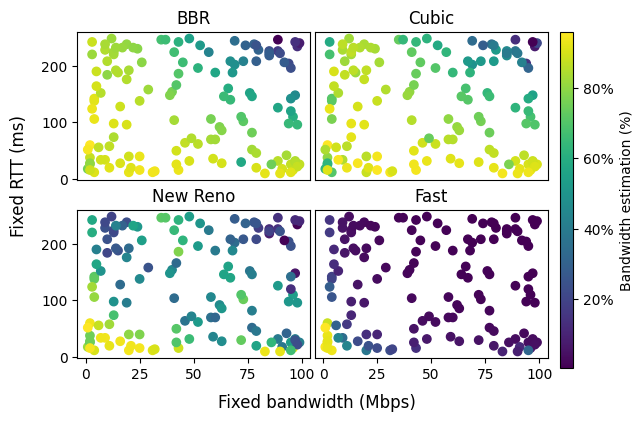

In [12]:
fig, axs = plt.subplots(2, 2)

axs[0, 0].scatter(subdf["expected_bw"], subdf["latency"],c=subdf[f"ratio_bbr_dl"])
axs[0, 0].set_title("BBR")
axs[0, 0].set_xticks([])

axs[0, 1].scatter(subdf["expected_bw"], subdf["latency"],c=subdf[f"ratio_cubic_dl"])
axs[0, 1].set_title("Cubic")
axs[0, 1].set_xticks([])
axs[0, 1].set_yticks([])

axs[1, 0].scatter(subdf["expected_bw"], subdf["latency"],c=subdf[f"ratio_reno_dl"])
axs[1, 0].set_title("New Reno")

sca = axs[1, 1].scatter(subdf["expected_bw"], subdf["latency"],c=subdf[f"ratio_fast_dl"])
axs[1, 1].set_title("Fast")
axs[1, 1].set_yticks([])

# Les valeurs [0.92, 0.1, 0.02, 0.8] contrôlent la position et la taille du colorbar
cax = fig.add_axes([0.88, 0.1, 0.02, 0.7])

cbar = plt.colorbar(sca, cax=cax, ticks=[0, 20, 40, 60, 80, 100])
cbar.ax.set_yticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])
cbar.set_label("Bandwidth estimation (%)")

# ax1.set_xscale("log")
# ax2.set_xscale("log")
# plt.legend(bbox_to_anchor=(1, 1.04))
fig.supylabel("Fixed RTT (ms)")
fig.supxlabel("Fixed bandwidth (Mbps)")
plt.subplots_adjust(wspace=0.02, hspace=0.2, top=0.8, bottom=0.12, right=.86)
plt.savefig("output/NesQUIClab/bulk_acc_dl.pdf")

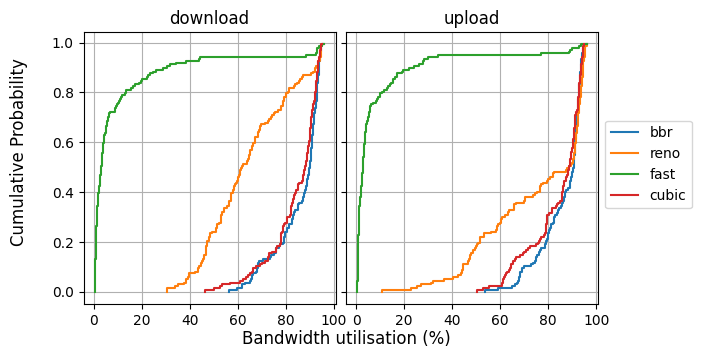

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(7, 4), sharex=True, sharey=True)

for cca in ["bbr", "reno", "fast", "cubic"]:
    d, c = get_cdf_data(subdf[f"ratio_{cca}_dl"])
    axs[0].step(d, c)
    d, c = get_cdf_data(subdf[f"ratio_{cca}_ul"])
    axs[1].step(d, c, label=cca)
axs[0].set_title("download")
axs[1].set_title("upload")
axs[0].grid()
axs[1].grid()
fig.supxlabel("Bandwidth utilisation (%)")
fig.supylabel("Cumulative Probability")
leg = plt.legend(bbox_to_anchor=(1, .7))
plt.subplots_adjust(wspace=0.04, hspace=0.2, top=0.8, bottom=0.12, right=.86)
plt.savefig("output/NesQUIClab/bulk_acc_cdf.pdf", bbox_extra_artists=(leg,))

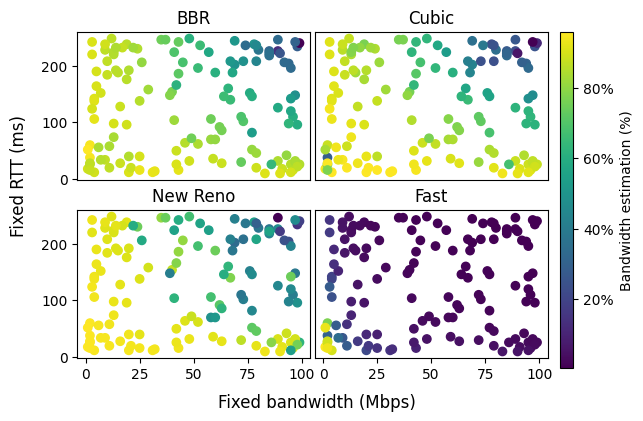

In [14]:
fig, axs = plt.subplots(2, 2)

axs[0, 0].scatter(subdf["expected_bw"], subdf["latency"],c=subdf[f"ratio_bbr_ul"])
axs[0, 0].set_title("BBR")
axs[0, 0].set_xticks([])

axs[0, 1].scatter(subdf["expected_bw"], subdf["latency"],c=subdf[f"ratio_cubic_ul"])
axs[0, 1].set_title("Cubic")
axs[0, 1].set_xticks([])
axs[0, 1].set_yticks([])

axs[1, 0].scatter(subdf["expected_bw"], subdf["latency"],c=subdf[f"ratio_reno_ul"])
axs[1, 0].set_title("New Reno")

sca = axs[1, 1].scatter(subdf["expected_bw"], subdf["latency"],c=subdf[f"ratio_fast_ul"])
axs[1, 1].set_title("Fast")
axs[1, 1].set_yticks([])

# Les valeurs [0.92, 0.1, 0.02, 0.8] contrôlent la position et la taille du colorbar
cax = fig.add_axes([0.88, 0.1, 0.02, 0.7])

cbar = plt.colorbar(sca, cax=cax, ticks=[0, 20, 40, 60, 80, 100])
cbar.ax.set_yticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])
cbar.set_label("Bandwidth estimation (%)")

# ax1.set_xscale("log")
# ax2.set_xscale("log")
# plt.legend(bbox_to_anchor=(1, 1.04))
fig.supylabel("Fixed RTT (ms)")
fig.supxlabel("Fixed bandwidth (Mbps)")
plt.subplots_adjust(wspace=0.02, hspace=0.2, top=0.8, bottom=0.12, right=.86)
plt.savefig("output/NesQUIClab/bulk_acc_ul.pdf")

In [15]:
df.loc[(df["expected"] < df["limited_upload_1.1"]) | (df["expected"] < df["limited_download_1.1"])]

,expected,latency,bulk_download_reno,bulk_download_bbr,bulk_download_cubic,bulk_download_fast,bulk_upload_reno,bulk_upload_bbr,bulk_upload_cubic,bulk_upload_fast,...,limited_download_0.8,limited_download_0.9,limited_download_1.0,limited_download_1.1,limited_upload_0.3,limited_upload_0.5,limited_upload_0.8,limited_upload_0.9,limited_upload_1.0,limited_upload_1.1
